# Building an Expected Goals Model for Shot-Event Data

By Jayanth Nair, A Springboard Capstone Project

***Introduction***

The following table contains statistics from a very famous (or rather infamous) game of football, obtained from Christoph Biermann's book Football Hackers. It describes the game with conventional statistical metrics.

|                             | Team A | Team B |
|-----------------------------|:------:|:------:|
|          Possession         |   52%  |   48%  |
| Passes into the 18 yard box |   19   |   11   |
|           Crosses           |   22   |   10   |
|           Corners           |    7   |    5   |
|      Dangerous attacks      |   55   |   34   |
|         Tackles won         |    5   |    1   |
|          Lost balls         |   69   |   76   |
|            Shots            |   18   |   14   |
|       Shots on Target       |   13   |   12   |

Upon first look, most people would conclude that Team A ran out comfortable winners. However, in reality Team B were the winners by some margin. These statistics are from the 2014 World Cup semi-final between Brazil and Germany. Team B were Germany. They won by 7 goals to 1.

Following the footsteps of baseball (Moneyball and more recently, Astroball) and basketball (Daryl Morey and the Houston Rockets), football/soccer is now undergoing a 'statistical revolution'. New statistical metrics are being developed which can quantify game scenarios better, thereby refining game tactics and player recruitment.

***What is Expected Goals?***

One of the relatively ubiquitous 'new' statistical metrics is Expected Goals (xG). xG essentially quantifies the quality of a shot by the probability of that shot being a goal. Intuitively, we know that a shot taken from outside the box is much less likely to be a goal than one being taken near the goal line. xG is a mere quantification of this intuitiveness. Some examples are below:

![Pavard Goal](https://media.giphy.com/media/jaJkRgaIT6wLayz5V7/giphy.gif)

This belter from Benjamin Pavard in the 2018 World Cup from outside the box will have a lower xG, while the goal below by Barcelona will have a much higher xG

![Barcelona Goal](https://media.giphy.com/media/zRqwfjscelwlO/giphy.gif)

***Why do we need xG?***

xG is an excellent predictor of how good a team is going forward, i.e attacking. The following is a snippet of the Premier League table on Nov 11, 2019 in descending order of points from Understat. (G is Goals scored and xG is, well, xG).

As you can see, the xG numbers match pretty well with the actual goals scored for each team, with some notable exceptions. Leicester City's attackers are ruthless in front of goal, outperforming their xG numbers significantly. Watford, Southampton and Manchester United on the other end seem to be underperforming as per their xG. 

![xGtable](https://i.imgur.com/LYwQilo.png)

Similary expected goals against or xGA can be used to quantify the quality of shots a team faces.  This can be used as an indicator of how good a team's defense is. Below is a table of goals allowed and xGA. At the top end of the table, Leicester and Sheffield United (!!!) seem to be outperforming their xGA numbers while Chelsea seem to be struggling.  The bottom three are all struggling with their defenses leaking goals. 

Both Watford and Southampton were at the receiving end of 0-6 and 0-9 maulings this season, so that will skew their numbers a little.

![xGatable](https://i.imgur.com/PWp0wQn.png)

***Objective***

My objective with this project is to create my own xG model. The dataset I am using is the [Statsbomb open dataset](https://github.com/statsbomb/open-data). Specifically, I will be using the women's soccer dataset which contains data from 2 seasons of the FA WSL, 1 season of NWSL and the 2018 women's world cup

The data contains 229 games and 5929 shots which should be sufficient to build a workable xG model

The approach will be hypothesis-driven. In any hypothesis driven approach, there needs to be a hypothesis tree which drives the data wrangling and exploration.  The hypothesis tree for this project is given below:

![decision_tree](https://imgur.com/wrmwByq.png)

Having done the EDA, statistical inference and selecting our machine learning model, it's time to finally apply our xG model! Let's use the 2018/2019 season data from the UK FA WSL as it has a complete season of matches to apply our model on

In the following workbook, I will demonstrate the application of the xG model in 
- evaluating players
- tell the story of a match
- evaluating teams

### Step 1 - Importing necessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
%matplotlib inline
pd.options.display.max_columns = 15
plt.style.use('fivethirtyeight')

/home/jayanth/anaconda3/envs/sklearn_venv/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
filepath = "/home/jayanth/Documents/statsbomb/open-data-master/data/matches/"
comp ="37"
season = "4"
season_path = filepath+comp+"/"+season+".json"

In [3]:
from collections import defaultdict

In [4]:
#creating a dictionary to hold match meta information
match_dict=defaultdict(list)

#creating a dataframe to hold match data from the 2018-18 season
df_matches=pd.read_json(season_path)
df_matches.head(5)

,match_id,match_date,kick_off,competition,season,home_team,away_team,...,match_status,last_updated,metadata,match_week,competition_stage,stadium,referee
0,19756,2019-04-17,20:00:00.000,"{'competition_id': 37, 'country_name': 'Englan...","{'season_id': 4, 'season_name': '2018/2019'}","{'home_team_id': 967, 'home_team_name': 'Evert...","{'away_team_id': 969, 'away_team_name': 'Birmi...",...,available,2019-06-23T15:32:29.914,"{'data_version': '1.1.0', 'shot_fidelity_versi...",16,"{'id': 1, 'name': 'Regular Season'}","{'id': 111, 'name': 'Haig Avenue', 'country': ...","{'id': 978, 'name': 'P. Clarke'}"
1,19744,2018-10-28,16:00:00.000,"{'competition_id': 37, 'country_name': 'Englan...","{'season_id': 4, 'season_name': '2018/2019'}","{'home_team_id': 973, 'home_team_name': 'Brist...","{'away_team_id': 968, 'away_team_name': 'Arsen...",...,available,2019-05-14T23:21:49.936384,{'data_version': '1.0.3'},7,"{'id': 1, 'name': 'Regular Season'}","{'id': 4055, 'name': 'Stoke Gifford Stadium', ...","{'id': 907, 'name': 'D. Lamport'}"
2,19799,2019-03-13,20:00:00.000,"{'competition_id': 37, 'country_name': 'Englan...","{'season_id': 4, 'season_name': '2018/2019'}","{'home_team_id': 966, 'home_team_name': 'Liver...","{'away_team_id': 971, 'away_team_name': 'Chels...",...,available,2019-05-15T00:04:56.284746,{'data_version': '1.1.0'},18,"{'id': 1, 'name': 'Regular Season'}","{'id': 579, 'name': 'Prenton Park', 'country':...","{'id': 933, 'name': 'J. Hull'}"
3,19738,2018-10-14,16:00:00.000,"{'competition_id': 37, 'country_name': 'Englan...","{'season_id': 4, 'season_name': '2018/2019'}","{'home_team_id': 973, 'home_team_name': 'Brist...","{'away_team_id': 969, 'away_team_name': 'Birmi...",...,available,2019-05-14T23:21:49.936384,{'data_version': '1.0.3'},5,"{'id': 1, 'name': 'Regular Season'}","{'id': 4055, 'name': 'Stoke Gifford Stadium', ...","{'id': 904, 'name': 'S. Allison'}"
4,19739,2018-10-21,15:00:00.000,"{'competition_id': 37, 'country_name': 'Englan...","{'season_id': 4, 'season_name': '2018/2019'}","{'home_team_id': 965, 'home_team_name': 'Brigh...","{'away_team_id': 746, 'away_team_name': 'Manch...",...,available,2019-05-14T23:21:49.936384,{'data_version': '1.0.3'},6,"{'id': 1, 'name': 'Regular Season'}","{'id': 4494, 'name': 'The Peoples Pension Stad...","{'id': 894, 'name': 'L. Oliver'}"


In [5]:
#populating the match dictionary with match ids as keys, home and away team names as values
for i in range(0,df_matches.shape[0]):
    key = df_matches.iloc[i,0]
    values=[df_matches.iloc[i,5]['home_team_name'],df_matches.iloc[i,6]['away_team_name']]
    match_dict[key]=values
    
    
len(match_dict.keys())

107

In [7]:
#initializing lists which will be used to create our events-data dataframe
eventspath = "/home/jayanth/Documents/statsbomb/open-data-master/data/events/"
match_id_list=[] #id of match
home_list=[] #home team
away_list=[] #away team
shots_list=[] # all shots
loc_list=[] #all shot locations
timestamp_list=[] #time at which shot was taken
outcome_name_list = [] #all shot outcomes
outcome_id_list=[] #all shot outcome ids as per data
bodypart_name_list = [] #bodypart involved in shot
bodypart_id_list=[] #bodypart ids as per data
technique_name_list = [] #technique used in shot
technique_id_list=[] #technique ids as per data
type_name_list = [] #play pattern names
type_id_list=[] #play pattern ids
first_time_list=[] #whether shot was taken without a preceding touch 
statsbomb_xg_list = [] #statsbomb's xG prediction
key_pass_type_list=[] #the key pass leading up to the shot
key_pass_pattern_list=[] # type of key pass event
player_list=[] #the player who took the shot
team_list=[] #the team the player belongs to
preceding_event_list=[]#the event preceding the shot
preceding_event_player_list=[]#the player involved in preceding event
preceding_event_team_list=[]#the team of the player involved
cross_list=[]#whether a key pass is a cross
cutback_list=[]#whether a key pass is a cutback

In [8]:
#extracting the above information
for match, teams in match_dict.items():
    matchname = str(match)
    path = eventspath+matchname+".json"
    df_events=pd.read_json(path)
    df_shots = df_events[['index','timestamp','shot','location','player','possession_team','team']].dropna()
    shots_list.append(df_shots.dropna().shape[0])
    loc_list.extend(list(df_shots['location'].values))
    timestamp_list.extend(list(df_shots['timestamp'].values))
    for i in range(0,len(df_shots)):
        match_id_list.append(match)
        home_list.append(teams[0])
        away_list.append(teams[1])
        outcome_name_list.append(df_shots.iloc[i][2]['outcome']['name'])
        outcome_id_list.append(df_shots.iloc[i][2]['outcome']['id'])
        bodypart_name_list.append(df_shots.iloc[i][2]['body_part']['name'])
        bodypart_id_list.append(df_shots.iloc[i][2]['body_part']['id'])
        technique_name_list.append(df_shots.iloc[i][2]['technique']['name'])
        technique_id_list.append(df_shots.iloc[i][2]['technique']['id'])
        type_name_list.append(df_shots.iloc[i][2]['type']['name'])
        type_id_list.append(df_shots.iloc[i][2]['type']['id'])
        player_list.append(df_shots.iloc[i][4]['name'])
        team_list.append(df_shots.iloc[i][5]['name'])
        
        #Whether a shot was a first time shot is indicated by a Boolean. Many shots are not first time shots
        #Error handling is used to not stop data extraction
        try:
            first_time_list.append(df_shots.iloc[i][2]['first_time'])
        except:
            first_time_list.append(False)
        
        #Many shots do not have a preceding key pass. Error handling is used in such cases
        try:
            key_pass = df_shots.iloc[i][2]['key_pass_id']
            filt1 = df_events['id']==key_pass
            pass_info = df_events[filt1].dropna(axis='columns')['pass']
            key_pass_type_list.append(pass_info.iloc[0]['height']['name'])
            pattern_info = df_events[filt1].dropna(axis='columns')['play_pattern']
            key_pass_pattern_list.append(pattern_info.iloc[0]['name'])
            try:
                if pass_info.iloc[0]['cross']==True:
                    cross_list.append(True)
                else:
                    cross_list.append(False)
            except KeyError:
                cross_list.append(False)
            try:
                if pass_info.iloc[0]['cut_back']==True:
                    cutback_list.append(True)
                else:
                    cutback_list.append(False)
            except KeyError:
                cutback_list.append(False)
                
        except KeyError:
            key_pass_type_list.append(np.nan)
            cutback_list.append(False)
            cross_list.append(False)
            key_pass_pattern_list.append(np.nan)
        #Extracting the event preceding the shot
        idx_filt = df_shots.iloc[i,0]-1
        filt = df_events['index']==idx_filt
        df_events_filt=df_events[filt].dropna(axis='columns')
        preceding_event_list.append(df_events_filt['type'].values[0]['name'])
        try:
            preceding_event_player_list.append(df_events_filt['player'].values[0]['name'])
        except:
            preceding_event_player_list.append(np.nan)
        preceding_event_team_list.append(df_events_filt['possession_team'].values[0]['name'])
        
        #extracting statsbomb xG
        statsbomb_xg_list.append(df_shots.iloc[i][2]['statsbomb_xg'])

In [9]:
def vectorize(pointa, pointb):
    '''
    Given two points, create a vector from the first to the second
    
    Arguments:
        pointa, pointb - x,y co-ordinates (list)
    
    Returns:
        vector from point a to point b
    '''
    return [pointb[0]-pointa[0], pointb[1]-pointa[1]]


def isInside(point_shot, point_goal1, point_goal2, point_freeze):
    '''
    Given the three vertices of a triangle, this function determines if a fourth
    point lies inside the triangle
    
    Arguments:
        point_shot - shot location x,y (list)
        point_goal1 and point_goal2 - goal edges x,y (list)
        point_freeze - player location x,y(list)
        
    Returns:
        True or False (boolean)
    
    '''
    v2 = vectorize(point_freeze, point_shot)
    v0 = vectorize(point_goal1, point_shot)
    v1 = vectorize(point_goal2, point_shot)

    u = (np.dot(v1, v1)*np.dot(v2, v0)-np.dot(v1, v0)*np.dot(v2, v1)) / \
        (np.dot(v0, v0)*np.dot(v1, v1)-np.dot(v0, v1)*np.dot(v1, v0))
    v = (np.dot(v0, v0)*np.dot(v2, v1)-np.dot(v0, v1)*np.dot(v2, v0)) / \
        (np.dot(v0, v0)*np.dot(v1, v1)-np.dot(v0, v1)*np.dot(v1, v0))

    if u < 0 or v < 0:
        return False
    elif u > 1 or v > 1:
        return False
    elif u+v > 1:
        return False
    else:
        return True

In [10]:
#defining edges of goal
goal_x1y1 = [120,36]
goal_x2y2 = [120,44]
pack_density_list = [] # initializing a list which will hold pack density values

In [11]:
#creating a pack density list
for match,_ in match_dict.items():
    matchname = str(match)
    path = eventspath+matchname+".json"
    df_events=pd.read_json(path)
    df_shots = df_events[['index','shot','location','player','possession_team']].dropna()
    
    for i in range(0,len(df_shots)):
        shot_loc=df_shots['location'].iloc[i]
        freeze_frame_list=[]
        # in cases of penalties, a freeze frame is not provided so a KeyError will be raised
        # using error handling to append 1 in such cases
        try:
            for j in range(0,len(df_shots['shot'].iloc[i]['freeze_frame'])):
                location=df_shots['shot'].iloc[i]['freeze_frame'][j]['location']
                freeze_frame_list.append(isInside(shot_loc,goal_x1y1,goal_x2y2,location))
        except KeyError:
            freeze_frame_list.append(1) 
        pack_density_list.append(sum(freeze_frame_list))

In [12]:
#creating our dataframe
df = pd.DataFrame(loc_list)

In [13]:
df.columns = ['shot_x','shot_y']
#calculating distance
df['shot_distance']=round(np.sqrt((df['shot_x']-120)**2+(df['shot_y']-40)**2),1)

#calculating angle using cosine rule
df['shot_a'] = np.sqrt((df['shot_x']-120)**2+(df['shot_y']-36)**2)
df['shot_b']=np.sqrt((df['shot_x']-120)**2+(df['shot_y']-44)**2)
df['shot_angle']=np.arccos((df['shot_a']**2+df['shot_b']**2-64)/(2*df['shot_a']*df['shot_b']))
df['shot_angle']=np.degrees(df['shot_angle'])
df['shot_angle']=round(df['shot_angle'],1)

In [14]:
#creating other columns
df['match_id']=match_id_list
df['home_team']=home_list
df['away_team']=away_list
df['timestamp']=timestamp_list
df['outcome_name']=outcome_name_list
df['outcome_id']=outcome_id_list
df['body_part_name']=bodypart_name_list
df['body_part_id']=bodypart_id_list
df['technique_name']=technique_name_list
df['technique_id']=technique_id_list
df['type_name']=type_name_list
df['type_id']=type_id_list
df['first_time']=first_time_list
df['preceding_event']=preceding_event_list
df['pack_density']=pack_density_list
df['shot_player']=player_list
df['shot_team']=team_list
df['key_pass_type']=key_pass_type_list
df['key_pass_pattern']=key_pass_pattern_list
df['isCross']=cross_list
df['isCutback']=cutback_list
df['preceding_event']=preceding_event_list
df['preceding_event_player']=preceding_event_player_list
df['preceding_event_team']=preceding_event_team_list
df['statsbomb_xg']=statsbomb_xg_list

### Step 3 - Checking for missing data and doing other modifications to our dataframe

In [15]:
df.isna().sum()

shot_x                      0
shot_y                      0
shot_distance               0
shot_a                      0
shot_b                      0
shot_angle                  0
match_id                    0
home_team                   0
away_team                   0
timestamp                   0
outcome_name                0
outcome_id                  0
body_part_name              0
body_part_id                0
technique_name              0
technique_id                0
type_name                   0
type_id                     0
first_time                  0
preceding_event             0
pack_density                0
shot_player                 0
shot_team                   0
key_pass_type             886
key_pass_pattern          886
isCross                     0
isCutback                   0
preceding_event_player      1
preceding_event_team        0
statsbomb_xg                0
dtype: int64

In [16]:
# we will drop the shot without any preceding event player
df=df.dropna(how='any',subset=['preceding_event_player'])

In [17]:
# some shots don't have a key pass associated with it, so we will impute the string 'None'
key_pass_type_list=[]
key_pass_pattern_list=[]
for index,row in df.iterrows():
        if row['key_pass_type'] not in ['Ground Pass','Low Pass','High Pass']:
            key_pass_type_list.append('None')
            key_pass_pattern_list.append('None')
        else:
            key_pass_type_list.append(row['key_pass_type'])
            key_pass_pattern_list.append(row['key_pass_pattern'])

df['key_pass_type']=key_pass_type_list
df['key_pass_pattern']=key_pass_pattern_list

In [18]:
df.isna().sum()

shot_x                    0
shot_y                    0
shot_distance             0
shot_a                    0
shot_b                    0
shot_angle                0
match_id                  0
home_team                 0
away_team                 0
timestamp                 0
outcome_name              0
outcome_id                0
body_part_name            0
body_part_id              0
technique_name            0
technique_id              0
type_name                 0
type_id                   0
first_time                0
preceding_event           0
pack_density              0
shot_player               0
shot_team                 0
key_pass_type             0
key_pass_pattern          0
isCross                   0
isCutback                 0
preceding_event_player    0
preceding_event_team      0
statsbomb_xg              0
dtype: int64

In [19]:
#converting outcome into a 1 or 0 vector with 1 being a goal and 0 not
isGoal=[]
isGoalBool = []
for outcome in df['outcome_name'].values:
    if outcome=='Goal':
        isGoal.append('Goal')
        isGoalBool.append(1)
    else:
        isGoal.append('Not Goal')
        isGoalBool.append(0)

df['isGoal']=isGoal
df['isGoalBool']=isGoalBool

In [20]:
#our model is not designed to work with cutbacks as there were very few of them in training
cross_cutback_forward = []
for index, rows in df.iterrows():
    if rows['key_pass_type']=='None':
        cross_cutback_forward.append('none')
    else:
        if (rows['isCross']==False) and (rows['isCutback']==False):
            cross_cutback_forward.append('forward')
        elif rows['isCross']==True:
            cross_cutback_forward.append('cross')
        elif rows['isCutback']==True:
            cross_cutback_forward.append('cutback')

df['cross_cutback_forward']=cross_cutback_forward
df=df[df['cross_cutback_forward']!='cutback']

In [21]:
# during the development of our model we grouped key pass patterns as either regular play or non-regular play
key_pass_pattern_list =[]
for index, rows in df.iterrows():
    if rows['key_pass_pattern']=='None':
        key_pass_pattern_list.append('none')
    else:
        if (rows['key_pass_pattern']=='Regular Play'):
            key_pass_pattern_list.append('Regular Play')
        else:
            key_pass_pattern_list.append('Non Regular Play') 

df['key_pass_pattern']=key_pass_pattern_list

In [22]:
# we also only consider open play shots
df = df[df.type_name=='Open Play']

In [23]:
# creating a first_time_or_carry column for our model
first_time_list =[]
for index, rows in df.iterrows():
    if rows['first_time']==True:
        first_time_list.append('first_time')
    else:
        first_time_list.append('carry')
        
df['first_time_or_carry']=first_time_list

In [24]:
# creating a column with the body parts without the 'other' values
body_part_list=[]
for index, rows in df.iterrows():
    if (rows['body_part_name']=='Right Foot') or (rows['body_part_name']=='Left Foot'):
        body_part_list.append('Foot')
    elif (rows['body_part_name']=='Head'):
        body_part_list.append('Head')
    else:
        body_part_list.append('Other')

df['body_part_name']=body_part_list
df=df[df.body_part_name != 'Other']

In [25]:
df.isna().any()

shot_x                    False
shot_y                    False
shot_distance             False
shot_a                    False
shot_b                    False
shot_angle                False
match_id                  False
home_team                 False
away_team                 False
timestamp                 False
outcome_name              False
outcome_id                False
body_part_name            False
body_part_id              False
technique_name            False
technique_id              False
type_name                 False
type_id                   False
first_time                False
preceding_event           False
pack_density              False
shot_player               False
shot_team                 False
key_pass_type             False
key_pass_pattern          False
isCross                   False
isCutback                 False
preceding_event_player    False
preceding_event_team      False
statsbomb_xg              False
isGoal                    False
isGoalBo

In [26]:
df.head(5)

,shot_x,shot_y,shot_distance,shot_a,shot_b,shot_angle,match_id,...,preceding_event_player,preceding_event_team,statsbomb_xg,isGoal,isGoalBool,cross_cutback_forward,first_time_or_carry
0,86.7,57.4,37.6,39.583456,35.894986,10.8,19756,...,Taylor Hinds,Everton LFC,0.013571,Not Goal,0,none,carry
1,93.9,34.5,26.7,26.143068,27.775169,16.7,19756,...,Inessa Kaagman,Everton LFC,0.049914,Not Goal,0,none,first_time
2,95.8,47.1,25.2,26.624237,24.397746,17.3,19756,...,Abbey-Leigh Stringer,Birmingham City WFC,0.022202,Not Goal,0,none,carry
3,109.6,54.5,17.8,21.222865,14.778701,15.4,19756,...,Inessa Kaagman,Everton LFC,0.078857,Goal,1,forward,carry
4,95.0,44.8,25.5,26.503585,25.012797,17.6,19756,...,Hayley Ladd,Birmingham City WFC,0.031914,Goal,1,none,carry


The reason we have so many features in this dataframe is for post-processing and visualization, even though our model itself only uses a subset of these features

### Step 4 - Machine Learning Pipeline

Let's extractor the predictor variables from this dataframe

In [27]:
X =df[['shot_distance', 'shot_angle', 'body_part_name', 'pack_density',
       'key_pass_type', 'key_pass_pattern','cross_cutback_forward', 'first_time_or_carry']]

In [28]:
X.head()

,shot_distance,shot_angle,body_part_name,pack_density,key_pass_type,key_pass_pattern,cross_cutback_forward,first_time_or_carry
0,37.6,10.8,Foot,2,None,none,none,carry
1,26.7,16.7,Foot,1,None,none,none,first_time
2,25.2,17.3,Foot,2,None,none,none,carry
3,17.8,15.4,Foot,1,Ground Pass,Non Regular Play,forward,carry
4,25.5,17.6,Foot,6,None,none,none,carry


Re-creating our pipeline

In [29]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [30]:
from sklearn.compose import ColumnTransformer

In [31]:
#intializing scaler and encoder
ohe=OneHotEncoder(sparse=False)
ss = StandardScaler()

#selecting categorical and numerical columns
cat_columns = ['body_part_name','key_pass_type','key_pass_pattern','cross_cutback_forward','first_time_or_carry']
num_columns = ['shot_distance','shot_angle','pack_density']

transformers = [('cat',ohe,cat_columns),('num',ss,num_columns)]

In [32]:
#using the passthrough option because we don't want to transform the statsbomb_xg column 
ct = ColumnTransformer(transformers,remainder='passthrough') 
X_t = ct.fit_transform(X)

Let's load our model and predict probabilities

In [33]:
from joblib import load
xg_model = load('best_xgb.joblib') #xgboost model - not to be confused with xg model
logit_model = load('best_logit.joblib')
gradboost_model = load('best_gradboost.joblib')

Since we are only interested in predicted probabilities, we will average out the predictions from the three best performing models

In [34]:
predicted_xg = 0.33*xg_model.predict_proba(X_t)+0.33*gradboost_model.predict_proba(X_t)+(1-0.66)*logit_model.predict_proba(X_t)

Let's append these xG predictions to our filtered dataframe

In [35]:
df['predicted_xg']=predicted_xg[:,1] #the positive class probabilities are our xG

In [36]:
df.head()

,shot_x,shot_y,shot_distance,shot_a,shot_b,shot_angle,match_id,...,preceding_event_team,statsbomb_xg,isGoal,isGoalBool,cross_cutback_forward,first_time_or_carry,predicted_xg
0,86.7,57.4,37.6,39.583456,35.894986,10.8,19756,...,Everton LFC,0.013571,Not Goal,0,none,carry,0.015922
1,93.9,34.5,26.7,26.143068,27.775169,16.7,19756,...,Everton LFC,0.049914,Not Goal,0,none,first_time,0.055809
2,95.8,47.1,25.2,26.624237,24.397746,17.3,19756,...,Birmingham City WFC,0.022202,Not Goal,0,none,carry,0.031603
3,109.6,54.5,17.8,21.222865,14.778701,15.4,19756,...,Everton LFC,0.078857,Goal,1,forward,carry,0.064807
4,95.0,44.8,25.5,26.503585,25.012797,17.6,19756,...,Birmingham City WFC,0.031914,Goal,1,none,carry,0.016461


Notice the similarities and differences between statsbomb_xg and predicted_xg. For our analysis, we will just consider predicted_xg

### Step 5 - Analysis and Visualization

Now that we have our xG predictions, let's do some analysis and visualization

#### First, let's do some player evaluations

In [40]:
# we will take a look at all the shots in our filtered open play shots data and find the players who 
# score more or less than the cumulative xG from all their shots
df_player_level = df[['shot_player','isGoalBool','predicted_xg']]
df_player_level=df_player_level.groupby(['shot_player']).sum()
df_player_level['xG_Diff']=df_player_level['isGoalBool']-df_player_level['predicted_xg']

df_player_level_xG=df_player_level.sort_values(by=['xG_Diff'],ascending=False)
df_player_level_xG=df_player_level_xG.round(1)
df_player_level_xG.columns=['goals','xG_sum','xG_Diff']
df_player_level_xG.head(10)

,goals,xG_sum,xG_Diff
shot_player,,,
Georgia Stanway,11,5.2,5.8
Vivianne Miedema,21,16.2,4.8
Fara Williams,8,3.5,4.5
Nikita Parris,15,11.3,3.7
Jordan Nobbs,8,4.3,3.7
Bethany Mead,7,3.7,3.3
Danielle van de Donk,10,6.9,3.1
Rinsola Babajide,4,1.5,2.5
Alisha Lehmann,6,3.6,2.4


Looking at the top 10 players grouped by amount of goals scored, we can see that there is a stand-out goalscorer - Vivianne Miedema from Arsenal. She significantly outperformed our xG model, which indicates either impeccable finishing.

Another impressive goalscorer is Georgia Stanway who had the biggest xG_Diff, scoring 11 when our model only predicted a total of 5 goals based on the features of her shots. 

Unsurprisingly, the top 10 is filled with forwards and attack minded midfielders who shoot more.

Now, let's look at the other end of the table at players who underperformed their cumulative xG

In [41]:
df_player_level_xG.tail(10)

,goals,xG_sum,xG_Diff
shot_player,,,
Pauline Bremer,0,1.3,-1.3
Niamh Charles,0,1.3,-1.3
Carla Humphrey,0,1.3,-1.3
Nadia Nadim,0,1.3,-1.3
Jessica Anne Clarke,1,2.4,-1.4
Angharad James,0,1.5,-1.5
Olivia Fergusson,1,2.5,-1.5
Iniabasi Anefiok Umotong,2,3.9,-1.9
Jill Scott,0,2.3,-2.3


Drew Spence, a midfielder from Chelsea, didn't have a great finishing season. Jill Scott is a defender who also took some shots but didn't score. Curiously, some of the names in the bottom 10 like Nadia Nadim and Pauline Bremer are forwards. Given how low their cumulative xG is, the reason they are in the bottom 10 could be a lack of playing time. 

A much better metric would be xG-per-90minutes, so that we normalize xG with the playing time. But we are not going to go into that here.

A reminder, that the above stats are for open play shots, the actual goals tally for many players will be different because of penalties, free-kicks etc.

Let's do a scatter plot to visualize the top 10 xG table

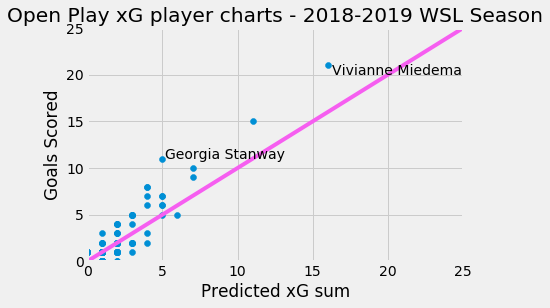

In [42]:
plt.scatter(round(df_player_level_xG['xG_sum'],0),df_player_level_xG['goals'])
plt.plot([0,25],[0,25],color="#f65ef0")
plt.xlabel('Predicted xG sum')
plt.ylabel('Goals Scored')
plt.xlim([0,25])
plt.ylim([0,25])
plt.annotate('Vivianne Miedema',xy=(16.3,21),xytext=(16.3,20))
plt.annotate('Georgia Stanway',xy=(5.2,11),xytext=(5.2,11));
plt.title('Open Play xG player charts - 2018-2019 WSL Season');

#### Second, let's harness the power of xG to tell the story of a match

In [43]:
match_level_xg = df[['shot_x','shot_y','match_id','home_team','away_team','timestamp','shot_player','shot_team','isGoalBool','predicted_xg']]

In [44]:
home_or_away = []
for index, rows in match_level_xg.iterrows():
    if rows['shot_team']==rows['home_team']:
        home_or_away.append('home')
    else:
        home_or_away.append('away')

match_level_xg['home_or_away']=home_or_away

/home/jayanth/anaconda3/envs/sklearn_venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [45]:
match_level_xg.head()

,shot_x,shot_y,match_id,home_team,away_team,timestamp,shot_player,shot_team,isGoalBool,predicted_xg,home_or_away
0,86.7,57.4,19756,Everton LFC,Birmingham City WFC,2020-02-04 00:04:36.133,Taylor Hinds,Everton LFC,0,0.015922,home
1,93.9,34.5,19756,Everton LFC,Birmingham City WFC,2020-02-04 00:04:40.569,Inessa Kaagman,Everton LFC,0,0.055809,home
2,95.8,47.1,19756,Everton LFC,Birmingham City WFC,2020-02-04 00:05:52.550,Lucy Quinn,Birmingham City WFC,0,0.031603,away
3,109.6,54.5,19756,Everton LFC,Birmingham City WFC,2020-02-04 00:07:03.244,Inessa Kaagman,Everton LFC,1,0.064807,home
4,95.0,44.8,19756,Everton LFC,Birmingham City WFC,2020-02-04 00:08:15.644,Hayley Ladd,Birmingham City WFC,1,0.016461,away


In [46]:
def time_series(df,home_or_away):
    '''
        Given the shots data from a match, this function reads the timestamp values 
        and returns the shot times for either the home or away team in the form of a list
    
    Arguments:
        df - shot data from a match with a 'home_or_away' column
        home_or_away - 'home' or 'away'
        
    Returns:
        time_series_final - list with time series for 'home' or 'away' team

    '''
    filt = df['home_or_away']==home_or_away
    df_time_series = df[filt]
    time_series_minutes = list(df_time_series.timestamp.dt.minute.values)
    time_series_final = []
    flag=0
    for i in range(0, len(time_series_minutes)):
        if i == 0:
            time_series_final.append(time_series_minutes[i])
        else:
            if flag == 0:
                if time_series_minutes[i] >= time_series_minutes[i - 1]:
                    time_series_final.append(time_series_minutes[i])
                else:
                    time_series_final.append(time_series_minutes[i] + 45)
                    flag = 1
            else:
                time_series_final.append(time_series_minutes[i] + 45)
        if i==len(time_series_minutes)-1:
            if time_series_final[i]<90:
                time_series_final.append(90)
                
    return time_series_final

In [47]:
def team_xg_accumulator(df,time_series, home_or_away):
    '''
    Given the shots data from a match and time series generated by the time_series function, 
    this function creates a list of cumulative xG for either the home or the away team
    
    Arguments:
        df - shot data from a match with a 'home_or_away' column
        time_series - time series list for either the 'home' or 'away' team
        home_or_away - 'home' or 'away'
        
    Returns:
        xg_sum - list of cumulative xG

    '''
    filt=df['home_or_away']==home_or_away
    df_team_shots = df[filt]
    xg_list=list(df_team_shots['predicted_xg'].values)
    xg_sum=[]
    for i in range(0,len(xg_list)):
        if i==0:
            xg_sum.append(xg_list[i])
        else:
            xg_sum.append(xg_list[i]+xg_sum[i-1])
        
    
    if len(xg_sum)<len(time_series):
        xg_sum.append(xg_sum[-1])
    return xg_sum

Going through the results from the 2018-2019 season, it was found that the Everton vs Brighton league match was very eventful and ended 3-3. This is a good candidate for visualization using xG.

Let's extract the data from this match first

In [48]:
filt1 = match_level_xg.home_team == 'Everton LFC'
filt2 = match_level_xg.away_team == 'Brighton & Hove Albion WFC'
filt3 = filt1 & filt2
df_eve_brighton=match_level_xg[filt3]
df_eve_brighton.head()

,shot_x,shot_y,match_id,home_team,away_team,timestamp,shot_player,shot_team,isGoalBool,predicted_xg,home_or_away
2793,117.0,38.0,19734,Everton LFC,Brighton & Hove Albion WFC,2020-02-04 00:00:45.560,Jodie Brett,Brighton & Hove Albion WFC,0,0.500634,away
2794,94.0,45.0,19734,Everton LFC,Brighton & Hove Albion WFC,2020-02-04 00:02:01.209,Danielle Buet,Brighton & Hove Albion WFC,1,0.022836,away
2795,85.0,16.0,19734,Everton LFC,Brighton & Hove Albion WFC,2020-02-04 00:13:43.153,Gabrielle George,Everton LFC,0,0.016926,home
2796,89.0,54.0,19734,Everton LFC,Brighton & Hove Albion WFC,2020-02-04 00:18:43.134,Jodie Brett,Brighton & Hove Albion WFC,0,0.038277,away
2797,108.0,23.0,19734,Everton LFC,Brighton & Hove Albion WFC,2020-02-04 00:26:31.944,Inessa Kaagman,Everton LFC,1,0.026109,home


Now, let's do a time trend plotting each team's cumulative xG and annotating points in time when goals were scored

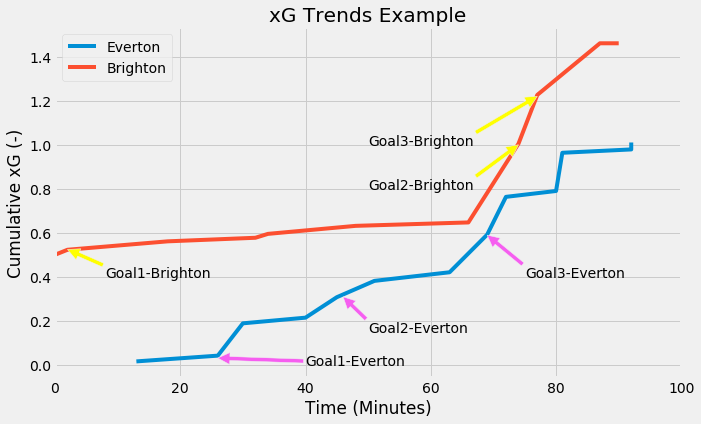

In [49]:
time_series_home=time_series(df_eve_brighton,'home')
time_series_away=time_series(df_eve_brighton,'away')

xg_sum_home = team_xg_accumulator(df_eve_brighton,time_series_home,'home')
xg_sum_away = team_xg_accumulator(df_eve_brighton,time_series_away,'away')

plt.figure(figsize=(10,6))

plt.plot(time_series_home,xg_sum_home,label='Everton');
plt.plot(time_series_away,xg_sum_away,label='Brighton');

plt.xlim([0,100])

plt.annotate('Goal1-Brighton',xy=(2,0.525),xytext=(8,0.4),arrowprops=dict(facecolor='yellow'))
plt.annotate('Goal2-Brighton',xy=(74,1.0),xytext=(50,0.8),arrowprops=dict(facecolor='yellow'))
plt.annotate('Goal3-Brighton',xy=(77,1.22),xytext=(50,1.0),arrowprops=dict(facecolor='yellow'))


plt.annotate('Goal1-Everton',xy=(26,0.032),xytext=(40,0),arrowprops=dict(facecolor='#f65ef0'))
plt.annotate('Goal2-Everton',xy=(46,0.31),xytext=(50,0.15),arrowprops=dict(facecolor='#f65ef0'))
plt.annotate('Goal3-Everton',xy=(69,0.59),xytext=(75,0.4),arrowprops=dict(facecolor='#f65ef0'))



plt.xlabel('Time (Minutes)')
plt.ylabel('Cumulative xG (-)')

plt.title('xG Trends Example')
plt.legend();

Interesting chart, yes? What story does this chart tell us? Here are some observations:
- Brighton started the game very well and created a very good shot at the very beginning of the game as the xG plot starts at around 0.45. But they didn't score from this shot. They scored shortly after though, so it was a very strong opening to the game - they were ahead within the first 5 minutes! The gain in xG from the opening shot to the scoring shot is not significant indicating that the scoring shot itself was not a high chance shot. A long range belter, perhaps?
- Everton on the other hand started the game on the backfoot despite being the home team. They didn't have a shot till the 10th minute. Even then the shots were not of the greatest quality as the cumulative xG is below 0.1 till the 25th minute. This indicates that Everton set up for the game very defensively and on the rare occassion they had a shot in the first 25 minutes, they were taking low xG shots (either from far out or out wide or into a packed defense etc.)
- After Brighton's great start, they eased the foot off the gas as there is no sharp jump in the cumulative xG plot in the first half. This indicates that they might have switched game plans to control the game now that they were in the lead
- Despite the low xG shots Everton were resigned to, they managed to level the game around the 27th minute with what appears to be a wonder goal since the xG is very very low! This seems to give them more attacking impetus as they start creating shots which are much better (look at the spikes in the cumulative xG plot). It seems for the rest of the first half, Everton were in control as Brighton did not create any more good shots. At the end of the first half, Everton capitalize and take the lead!
- The second half resumes where the first half finished with Everton creating better shots while Brighton are struggling to create good shots. Everton score another in the 70th minute and are now 3-1 up!
- At this point Brighton have made a tactical switch and are now focussing on attacking as much as possible. This pays off as they score from two very good shots between minutes 75 and 80. Now the game is tied up!
- From this point on, both teams are trying to win the game as we can see sharp spikes in the xG plots, indicating defensive lapses on both sides.
- Overall the cumulative open play xG predicted 1.4 goals for Brighton and 1.0 goal for Everton
- Both teams out-performed their xG either because of superb finishing or defensive lapses
- Despite the final score, Brighton will be disappointed to not have won this game as they created significantly better chances. They had two great chances, one each in the beginning and end of the game, and missing them proved costly

Another way of visualizing this match story is to do a pitch plot and look at the positions where the shots were taken

In [50]:
from matplotlib.patches import Arc

In [51]:
# plotting shots on to a pitch

def pitch_creator(size=(10,6)):
    with plt.style.context('bmh'):
        fig = plt.figure(figsize=size)
        plt.axis([60, 125, -10, 90])
        plt.grid(False)


        plt.plot([60, 60], [0, 80], color='black')
        plt.plot([120, 120], [0, 80], color="black")
        plt.plot([60, 120], [0, 0], color='black')
        plt.plot([60, 120], [80, 80], color='black')

        centreCircle = plt.Circle((60, 40), 10, color='black', fill=False)

        # right penalty area
        plt.plot([120, 102], [18, 18], color='black')
        plt.plot([102, 102], [18, 62], color='black')
        plt.plot([102, 120], [62, 62], color='black')

        # right six yard box
        plt.plot([120, 114], [30, 30], color='black')
        plt.plot([114, 114], [30, 50], color='black')
        plt.plot([114, 120], [50, 50], color='black')


        # right goal posts
        plt.plot([120, 122], [36, 36], color='black')
        plt.plot([120, 122], [44, 44], color='black')
        plt.plot([122, 122], [36, 44], color='black')


        # right Arc
        rightArc = Arc((108, 40), height=18.3, width=18.3, angle=0,
                       theta1=130, theta2=230, color='red')

        ax = plt.gca()
        ax.add_patch(centreCircle)
        ax.add_patch(rightArc)
        ax.set_ylim(ax.get_ylim()[::-1])
        return fig


In [52]:
df_home=df_eve_brighton[df_eve_brighton['home_or_away']=='home']
df_away=df_eve_brighton[df_eve_brighton['home_or_away']=='away']

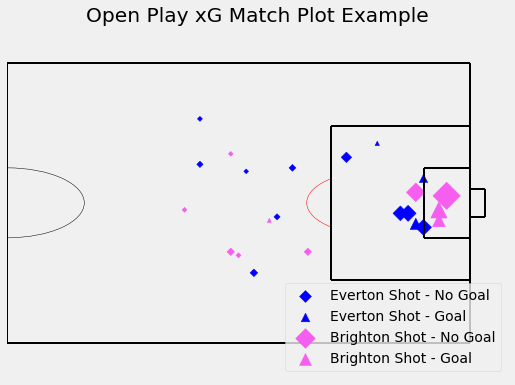

In [53]:
home_non_goals_x = df_home[df_home.isGoalBool==0].shot_x.values
home_non_goals_y = df_home[df_home.isGoalBool==0].shot_y.values
home_non_goals_xg = df_home[df_home.isGoalBool==0].predicted_xg.values

home_goals_x = df_home[df_home.isGoalBool==1].shot_x.values
home_goals_y = df_home[df_home.isGoalBool==1].shot_y.values
home_goals_xg = df_home[df_home.isGoalBool==1].predicted_xg.values

away_non_goals_x = df_away[df_away.isGoalBool==0].shot_x.values
away_non_goals_y = df_away[df_away.isGoalBool==0].shot_y.values
away_non_goals_xg = df_away[df_away.isGoalBool==0].predicted_xg.values

away_goals_x = df_away[df_away.isGoalBool==1].shot_x.values
away_goals_y = df_away[df_away.isGoalBool==1].shot_y.values
away_goals_xg = df_away[df_away.isGoalBool==1].predicted_xg.values


plt1=pitch_creator(size=(8,6))
plt1=plt.scatter(home_non_goals_x,home_non_goals_y, s=home_non_goals_xg*750,c="#0000ff",marker="D",label='Everton Shot - No Goal')
plt1=plt.scatter(home_goals_x,home_goals_y, s=home_goals_xg*750,c="#0000ff",marker="^",label='Everton Shot - Goal')

plt1=plt.scatter(away_non_goals_x,away_non_goals_y, s=away_non_goals_xg*750,c="#f65ef0",marker="D",label='Brighton Shot - No Goal')
plt1=plt.scatter(away_goals_x,away_goals_y, s=away_goals_xg*750,c="#f65ef0",marker="^",label='Brighton Shot - Goal')

plt.axis('off');
plt.legend(loc='lower right')
plt.title('Open Play xG Match Plot Example');

The above pitch map indicates xG using marker size.

Brighton had some good shots from close to the goal. The biggest xG chance was close to the goal and missed by Brighton. Also notice the Brighton goal they scored from outside the box. This was the first goal Brighton scored.

The first goal Everton scored was actually inside the penalty box but from a tight angle.

#### Finally, let's use xG to evaluate all the teams who competed in the 2018-19 WSL season

In [58]:
season_xg=match_level_xg[['shot_team','isGoalBool','predicted_xg']].groupby('shot_team').sum()

season_xg = season_xg.round(1)
season_xg['xgDiff']=season_xg['isGoalBool']-season_xg['predicted_xg']
season_xg.columns=['Goals','Cumulative xG','xgDiff']
season_xg['Actual League Position'] = [1,4,9,6,3,10,8,2,5,7,11]
season_xg.sort_values(by='Cumulative xG',ascending=False)

,Goals,Cumulative xG,xgDiff,Actual League Position
shot_team,,,,
Arsenal WFC,61,42.4,18.6,1
Manchester City WFC,47,39.1,7.9,2
Chelsea FCW,35,37.7,-2.7,3
Reading WFC,29,23.2,5.8,5
Birmingham City WFC,25,22.0,3.0,4
West Ham United LFC,21,20.4,0.6,7
Brighton & Hove Albion WFC,17,20.0,-3.0,9
Everton LFC,13,17.3,-4.3,10
Liverpool WFC,13,15.2,-2.2,8


The above is the league table sorted by cumulative xG from open play shots. Looking at the final league positions and comparing it to the xG table, we can see that open play xG is a pretty decent predictor of team performance. 

Arsenal significantly out-performed xG numbers and rightfully finished on top while Yeovil were woeful with creating good shots and finished at the very bottom. Everton significantly under-performed their xG and actually finished second-to-last but according to xG they should have finished 8th. While Bristol City outperformed their xG numbers and finished 6th while xG had them pinned closed to the bottom

Let's do some pitch plots to analyze where teams took their shots

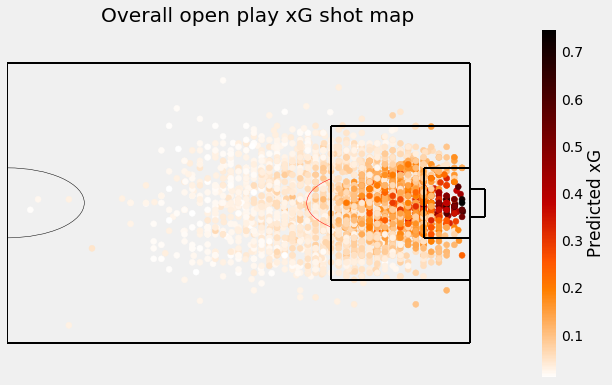

In [60]:
plt1 = pitch_creator()
plt1 = plt.scatter(df['shot_x'],df['shot_y'],c=df['predicted_xg'],cmap='gist_heat_r')
plt.axis('off')
cbar=plt.colorbar()
cbar.set_label('Predicted xG')
plt.title('Overall open play xG shot map');

Most good quality shots are within the penalty box. The highest xG predicted by the model is roughly 0.75, so statistically there is no shot that is 'an absolute sitter'!

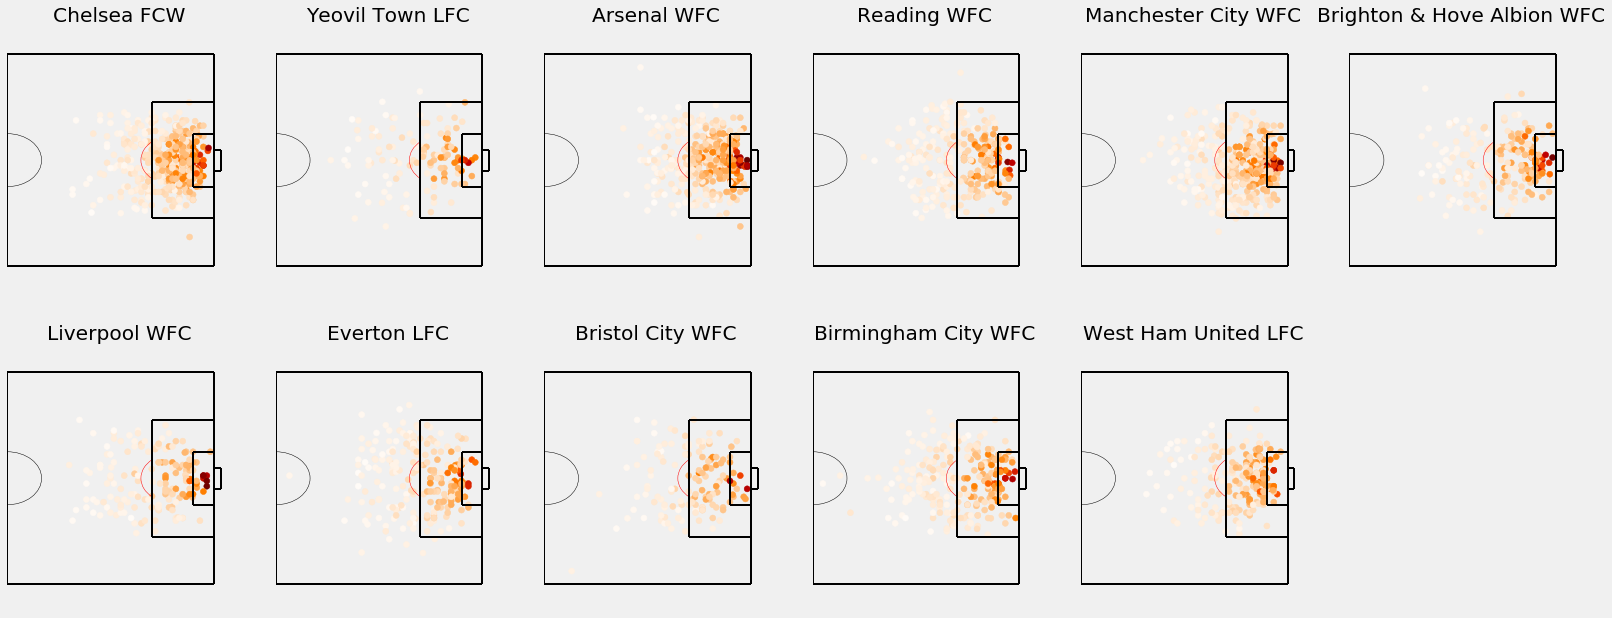

In [63]:
i=1
fig=plt.figure(figsize=(25,10))
with plt.style.context('bmh'):
    for team in set(df.shot_team.values):
        filt1 = df.shot_team == team
        df_team = df[filt1]

        ax = fig.add_subplot(2,6,i)

        ax.axis([60, 125, -10, 90])
        ax.grid(False)


        ax.plot([60, 60], [0, 80], color='black')
        ax.plot([120, 120], [0, 80], color="black")
        ax.plot([60, 120], [0, 0], color='black')
        ax.plot([60, 120], [80, 80], color='black')

        centreCircle = plt.Circle((60, 40), 10, color='black', fill=False)

        # right penalty area
        ax.plot([120, 102], [18, 18], color='black')
        ax.plot([102, 102], [18, 62], color='black')
        ax.plot([102, 120], [62, 62], color='black')

        # right six yard box
        ax.plot([120, 114], [30, 30], color='black')
        ax.plot([114, 114], [30, 50], color='black')
        ax.plot([114, 120], [50, 50], color='black')


        # right goal posts
        ax.plot([120, 122], [36, 36], color='black')
        ax.plot([120, 122], [44, 44], color='black')
        ax.plot([122, 122], [36, 44], color='black')


        # right Arc
        rightArc = Arc((108, 40), height=18.3, width=18.3, angle=0,
                       theta1=130, theta2=230, color='red')

        ax = plt.gca()
        ax.add_patch(centreCircle)
        ax.add_patch(rightArc)
        ax.set_ylim(ax.get_ylim()[::-1])


        ax.scatter(df_team['shot_x'],df_team['shot_y'],c=df_team['predicted_xg'],cmap='gist_heat_r',vmin=0,vmax=1)
        ax.axis('off')

        ax.set_title(team)
        i+=1


Arsenal, Man City and Chelsea where creating good quality shots from within the penalty box a lot of the time while teams like Yeovil were creating fewer shots overall and most shots were from outside the box. This indicates a lack of strength in attack. They were playing 'out of their league' and ended up being relegated to a lower division

There are many other ways to visualize soccer in terms of xG. For e.g: xG can also be used to quantify how good your defense is by looking at the xGA (xG Against). If the xGA is low, it indicates a good defense.

But for the purposes of this project, this was not studied.

I hope this was informative and fun and perhaps changed the way you watch soccer atleast a tiny bit!